<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Feature Engineering</h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (features) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook](https://www.kaggle.com/code/rogeriodelfim/tps-may-2021-01-eda-baseline-xgb) de 0.93935 com XGBoost.

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    #!pip install --q pycaret

    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import math
import sklearn.exceptions
import datetime
import shap
import glob

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import lightgbm          as lgb
import scikitplot        as skplt

In [4]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, Normalizer 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from datetime                import datetime
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

In [5]:
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.utils.class_weight import compute_sample_weight
from scipy                      import stats
from scipy.cluster              import hierarchy as hc
from math                       import factorial
from scipy.stats                import mode
from collections                import Counter
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.calibration        import CalibrationDisplay
from sklearn.preprocessing      import PolynomialFeatures

## 1.3. Funções

In [6]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [7]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [8]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [9]:
def scaler_MaxAbsScaler_StandardScaler(df):    
    sc_mm = MaxAbsScaler()
    sc_st = StandardScaler()     
    col = df.columns
    df  = sc_mm.fit_transform(df)
    df  = pd.DataFrame(sc_st.fit_transform(df), columns=col)    
    return df

In [10]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [11]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False, print_graf=True):
    
    df = df.corr(method ='pearson').round(5)

    if print_graf: 
        # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
        mask = np.zeros_like(df)
        mask[np.triu_indices_from(mask)] = True

        # Making a plot
        ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

        ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

        plt.setp(ax.get_xticklabels(), 
                 rotation      = 90, 
                 ha            = "right",
                 rotation_mode = "anchor", 
                 weight        = "normal")

        plt.setp(ax.get_yticklabels(), 
                 weight        = "normal",
                 rotation_mode = "anchor", 
                 rotation      = 0, 
                 ha            = "right");

    if print_var: 
        
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        if len(df_corr)>0:            
            print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
            df_corr.columns =  ['var_1', 'var_2', 'corr']
            display(df_corr)
        else: 
            print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))

In [13]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for {}'.format(label))
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

## 1.4. Criar estrutura de pasta 


In [14]:
path        = '/content/drive/MyDrive/kaggle/Tabular Playground Series/05 - Maio/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'target'
path_automl = 'automl/'

In [15]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [16]:
df1_train     = pd.read_csv(path + path_data + 'train.csv')
df1_test      = pd.read_csv(path + path_data + 'test.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((900000, 33), (700000, 32), (700000, 2))

### 1.5.3. Visualizar os dados 

In [17]:
df1_train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [18]:
df1_test.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,0,0,5,1,1,2,2,0,1,-1.128371,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,0,2,1,3,0,0,0,2,0,-4.424098,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,1,1,3,2,2,4,1,0,3,-1.523864,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,2,1,5,0,3,3,1,4,2,-1.404597,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,0,0,3,0,1,2,0,2,2,-1.968516,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


In [19]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. PROCESSAMENTO </h1>    
</div>

In [20]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

del df1_train , df1_test 

df2_train.shape, df2_test.shape

((900000, 33), (700000, 32))

## 2.1. Excluir variáveis

In [21]:
df2_train.drop('id', axis=1, inplace=True)
df2_test.drop('id', axis=1, inplace=True)

## 2.2. Duplicados 

In [22]:
df2_train.duplicated().sum()

0

In [23]:
df2_test.duplicated().sum()

0

## 2.3. Redução dos datasets

In [24]:
df2_train = reduce_memory_usage(df2_train)
df2_test  = reduce_memory_usage(df2_test)

Mem. usage decreased to 47.21 Mb (78.5% reduction)
Mem. usage decreased to 36.05 Mb (78.2% reduction)


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. FEATURE ENGINEERING </h1>    
</div>



Nesta parte do processo vamos criar diversas variávies com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial **fe_**, a cada criação de novas variáveis vamos treinar o modelo __XGBoost__ e analisar a performance das novas variáveis na identifição de novos padrões.

In [25]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

In [26]:
feature_all   = df3_test.columns.to_list()
feature_float = df3_test.select_dtypes(np.float16).columns.to_list()
feature_cat   = df3_test.select_dtypes(np.int8).columns.to_list()

print('Variáveis Númericas')
print(feature_float,)
print()
print('Variáveis Categóricas')
print(feature_cat)

Variáveis Númericas
['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28']

Variáveis Categóricas
['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30']


## 3.1. Feature F_27

Vamos criar uma função para tratamento e geração das novas variáveis. 

In [27]:
def create_feature_F27_Statistic_Interaction(df_, path_, file_):

    print('Gerando {}'.format(file_))
    
    time_start     = datetime.now()
    time_for_start = datetime.now()
    values_list    = []
    df             = pd.DataFrame()
    feature_27     = ''

       # Feature engineering variable F_27   
    for f in df_['f_27']: 
        feature_27 +=f 

    feature_27 = set(feature_27)
    feature_27 =  ['fe_27_'+ str(f).lower() for f in feature_27]
    feature_27.sort() 
    feature_27.append('fe_27_count_unique')
    feature_27.append('fe_27_count_zero')
    feature_27.append('fe_27_mean')
    feature_27.append('fe_27_sum')    
    feature_27.append('fe_27_std')
    
    for i, col in enumerate(df_['f_27'].values):
        
        col_dic= Counter(col)    
        values = [col_dic.get('A') if col_dic.get('A') is not None else 0,
                  col_dic.get('B') if col_dic.get('B') is not None else 0,
                  col_dic.get('C') if col_dic.get('C') is not None else 0,
                  col_dic.get('D') if col_dic.get('D') is not None else 0,
                  col_dic.get('E') if col_dic.get('E') is not None else 0,
                  col_dic.get('F') if col_dic.get('F') is not None else 0,
                  col_dic.get('G') if col_dic.get('G') is not None else 0,
                  col_dic.get('H') if col_dic.get('H') is not None else 0,
                  col_dic.get('I') if col_dic.get('I') is not None else 0,
                  col_dic.get('J') if col_dic.get('J') is not None else 0,
                  col_dic.get('K') if col_dic.get('K') is not None else 0,
                  col_dic.get('L') if col_dic.get('L') is not None else 0,
                  col_dic.get('M') if col_dic.get('M') is not None else 0,
                  col_dic.get('N') if col_dic.get('N') is not None else 0,
                  col_dic.get('O') if col_dic.get('O') is not None else 0,
                  col_dic.get('P') if col_dic.get('P') is not None else 0,
                  col_dic.get('Q') if col_dic.get('Q') is not None else 0,
                  col_dic.get('R') if col_dic.get('R') is not None else 0,
                  col_dic.get('S') if col_dic.get('S') is not None else 0,
                  col_dic.get('T') if col_dic.get('T') is not None else 0,
                  len(set(col_dic))]
        
        count_zero  = len([v for v in values if v==0])
        cols_value  = ([v for v in values if v!=0]) [:-1]
        values_std  = np.std(cols_value)
        values_mean = np.mean(cols_value)
        values_sum  = np.sum(cols_value)
        
        values.append(count_zero)        
        values.append(values_mean)
        values.append(values_sum)
        values.append(values_std)
        
        values_list.append(values)

        if i>0:            
            if i%100000==0:
                time_end   = diff(time_for_start, datetime.now())                
                print('=> {} -  {}'.format(i, time_end))
                time_for_start = datetime.now()
                
    
    df = pd.DataFrame(values_list, columns=feature_27)
    
    #
    # Interações de recursos: crie três recursos ternários
    # Todo recurso ternário pode ter os valores -1, 0 e +1    
    # referencias: https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction
    #              https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    #              https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook
    df_['fe_02_21']      = (df_.f_21 + df_.f_02 > 5.2).astype(int) - (df_.f_21 + df_.f_02 < -5.3).astype(int)
    df_['fe_05_22']      = (df_.f_22 + df_.f_05 > 5.1).astype(int) - (df_.f_22 + df_.f_05 < -5.4).astype(int)
    i_00_01_26           = df_.f_00 + df_.f_01 + df_.f_26    
    df_['fe_i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    

    df_[feature_27]   = df.values
    
    df_.drop('f_27', axis=1, inplace=True)
    
    feature_type_int = feature_27
    feature_type_int.remove('fe_27_std')
    feature_type_int.remove('fe_27_mean')
    
    for col in feature_type_int: 
        df_[col] = df_[col].astype(np.int8)
       
    df_['fe_27_std']  = df_['fe_27_std'].astype(np.float16)
    df_['fe_27_mean'] = df_['fe_27_mean'].astype(np.float16)

    # Salva dataset    
    jb.dump(df_, path_ + 'Data/pkl/'+ file_ +'.pkl.z')
    
    print('=> {} -  {}'.format(i+1, diff(time_start, datetime.now())))   
    print()
    
    free_gpu_cache()
    
    return df_

In [28]:
%%time
df3_train_fe_1 = create_feature_F27_Statistic_Interaction(df3_train.copy(), path_=path, file_='df3_train_fe_1')
df3_test_fe_1  = create_feature_F27_Statistic_Interaction(df3_test.copy(), path_=path, file_='df3_test_fe_1')

df3_train_fe_1.filter(regex=r'fe_27')#.info()

Gerando df3_train_fe_1
=> 100000 -  0h 0m 9s
=> 200000 -  0h 0m 6s
=> 300000 -  0h 0m 6s
=> 400000 -  0h 0m 6s
=> 500000 -  0h 0m 6s
=> 600000 -  0h 0m 6s
=> 700000 -  0h 0m 7s
=> 800000 -  0h 0m 6s
=> 900000 -  0h 1m 12s

Gerando df3_test_fe_1
=> 100000 -  0h 0m 8s
=> 200000 -  0h 0m 6s
=> 300000 -  0h 0m 6s
=> 400000 -  0h 0m 6s
=> 500000 -  0h 0m 6s
=> 600000 -  0h 0m 6s
=> 700000 -  0h 0m 54s

CPU times: total: 2min 7s
Wall time: 2min 7s


,fe_27_a,fe_27_b,fe_27_c,fe_27_d,fe_27_e,fe_27_f,fe_27_g,fe_27_h,fe_27_i,fe_27_j,fe_27_k,fe_27_l,fe_27_m,fe_27_n,fe_27_o,fe_27_p,fe_27_q,fe_27_r,fe_27_s,fe_27_t,fe_27_count_unique,fe_27_count_zero,fe_27_mean,fe_27_sum,fe_27_std
0,4,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,17,3.333984,10,0.942871
1,3,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,2.000000,10,1.264648
2,5,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.490234
3,2,5,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,2.500000,10,1.500000
4,0,4,2,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.105469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,1,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,2.000000,10,2.000000
899996,0,6,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,5,15,2.000000,10,2.000000
899997,2,4,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,15,2.000000,10,1.095703
899998,5,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,2.500000,10,1.658203


In [30]:
df3_train_fe_1.filter(regex=r'fe_').head()

,fe_02_21,fe_05_22,fe_i_00_01_26,fe_27_a,fe_27_b,fe_27_c,fe_27_d,fe_27_e,fe_27_f,fe_27_g,fe_27_h,fe_27_i,fe_27_j,fe_27_k,fe_27_l,fe_27_m,fe_27_n,fe_27_o,fe_27_p,fe_27_q,fe_27_r,fe_27_s,fe_27_t,fe_27_count_unique,fe_27_count_zero,fe_27_mean,fe_27_sum,fe_27_std
0,0,0,0,4,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,17,3.333984,10,0.942871
1,0,0,0,3,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,2.000000,10,1.264648
2,0,0,0,5,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.490234
3,0,0,0,2,5,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,2.500000,10,1.500000
4,0,0,1,0,4,2,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.105469


- Vamos dar uma olhada na correlação das variavies. 

In [31]:
graf_feature_corr(df         = df3_train_fe_1.copy(), 
                  annot_     = False, 
                  threshold  = .6, 
                  print_var  = True, 
                  print_graf = False);

Variáveis autocorrelacionadas threshold=0.60


,var_1,var_2,corr
0,fe_27_a,fe_27_b,-0.61563
1,fe_27_b,fe_27_a,-0.61563
2,fe_27_count_unique,fe_27_count_zero,-1.00000
3,fe_27_count_unique,fe_27_mean,-0.95943
4,fe_27_count_zero,fe_27_count_unique,-1.00000
5,fe_27_count_zero,fe_27_mean,0.95943
6,fe_27_mean,fe_27_count_unique,-0.95943
7,fe_27_mean,fe_27_count_zero,0.95943


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Observamos algumas variariveis autocorrelacionadas, as quais devemos excluir da nossa modelagem. 
</div>

### 3.1.1. Modelagem

In [32]:
df3_train_fe_1 = jb.load(path + 'Data/pkl/df3_train_fe_1.pkl.z' )
df3_test_fe_1  = jb.load(path + 'Data/pkl/df3_test_fe_1.pkl.z' )

df3_train_fe_1.shape, df3_test_fe_1.shape

((900000, 59), (700000, 58))

In [34]:
 def delete_files(namefile):
                
        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))

In [35]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_) + '.csv'
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path + 'Data/submission/' + model_name_, index=False)

In [36]:
def model_train(model_, model_name_, X_, X_train_, X_valid_, X_test_, sc_, print_feature_cor_=True, 
                salve_model_=True):
    
    delete_files(model_name_)
    
    cols       = X_test.columns.to_list()    
    sc_.fit_transform(X_train_[cols])
      
    X_sc       = pd.DataFrame(sc_.transform(X_[cols]), columns=cols)
    X_train_sc = pd.DataFrame(sc_.transform(X_train_[cols]), columns=cols)
    X_valid_sc = pd.DataFrame(sc_.transform(X_valid_[cols]), columns=cols)
    X_test_sc  = pd.DataFrame(sc_.transform(X_test_[cols]), columns=cols)

    #model = lgb.LGBMClassifier(**params)
    model_.fit(X_train_sc, y_train)

    y_pred_proba     = model.predict_proba(X_valid_sc)
    y_pred_proba_neg = y_pred_proba[:,0]
    y_pred_proba_pos = y_pred_proba[:,1]
    y_pred           = (y_pred_proba_pos>.5).astype(int)

    y_pred_proba_ts  = model.predict_proba(X_test_sc)[:,1]
    y_pred_ts        = (y_pred_proba_ts>.5).astype(int)

    auc   = metrics.roc_auc_score(y_valid, y_pred_proba_pos)
    f1    = metrics.f1_score(y_valid, y_pred)
    lloss = metrics.log_loss (y_valid, y_pred)

    print ('AUC: {:2.5f} - F1-score: {:2.5f} - L. loss: {:2.5f}'.format(auc, f1, lloss))
    print()

    # Vamos agora selecionar um resultado que previu como positivo
    print('Probabilidade do modelo')
    print('Prever negativo: {:2.5f}'.format(np.mean(y_pred_proba_neg)))
    print('Prever positivo: {:2.5f}'.format(np.mean(y_pred_proba_pos)))
    print()

    model_name =  model_name_.format(auc)
    
    if salve_model_:
        y_pred_proba_X = pd.DataFrame(model.predict_proba(X_sc)[:,1]).reset_index()         
        y_pred_proba_X.columns = ['index','y_proba']  

        # Salvar as predições    
        save_data_model(model_             = model, 
                        model_name_        = model_name + '_score_{:2.5f}_seed_{}', 
                        path_              = path, 
                        y_pred_train_prob_ = y_pred_proba_X, 
                        y_pred_test_prob_  = y_pred_proba_ts, 
                        y_pred_test_subm_  = y_pred_proba_ts, 
                        score_             = auc, 
                        seed_              = seed, 
                        level_             = '1', 
                        target_            = target, 
                        cutoff_value_      = .98) 

    if print_feature_cor_:
        graf_feature_corr(df         = X_train_sc.copy(), 
                          annot_     = False, 
                          threshold  = .6, 
                          print_var  = True, 
                          print_graf = False);

    print()

    free_gpu_cache()
    
    return model, sc_, y_pred_proba_neg, y_pred_proba_pos

In [37]:
%%time

seed   = 12359
params = {'objective'         : 'binary:logistic',             
          'eval_metric'       : 'auc',            
          'n_estimators'      : 1000,             
          'random_state'      : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model  = xgb.XGBClassifier(**params)
scaler = QuantileTransformer(output_distribution='normal', random_state=0)

feature_drop_cor = ['fe_27_sum', 'fe_27_count_zero', 'fe_27_count_unique']

X      = df3_train_fe_1.drop(target, axis=1).copy()
X      = X.drop(feature_drop_cor, axis=1).copy()
y      = df3_train_fe_1[target]
X_test = df3_test_fe_1.drop(feature_drop_cor, axis=1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.29,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = seed)

model, sc, y_pred_proba_neg, y_pred_proba_pos = \
    model_train(model, 'xgb_fe_01', 
                X, 
                X_train, 
                X_valid, 
                X_test, 
                scaler)
# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832

AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832

Probabilidade do modelo
Prever negativo: 0.51413
Prever positivo: 0.48587

Não tem variáveis autocorrelacionadas threshold=0.60

CPU times: total: 2min 12s
Wall time: 1min 53s


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>    
Olhando os números acima, batemos a baseline com a criação de novas variáveis, o modelo tem uma maior facilidade de prever a classe negativa.
    
Um ponte importante que devemos destacar é a exclusão das variáveis: 
- fe_27_sum: não tem valor preditivo para o modelo;
- fe_27_count_zero e fe_27_count_unique: são variáveis que tem autocorrelacionadas com outras.
</div>

### 3.1.2. Análise 

#### 3.1.2.1. Real x Previsão

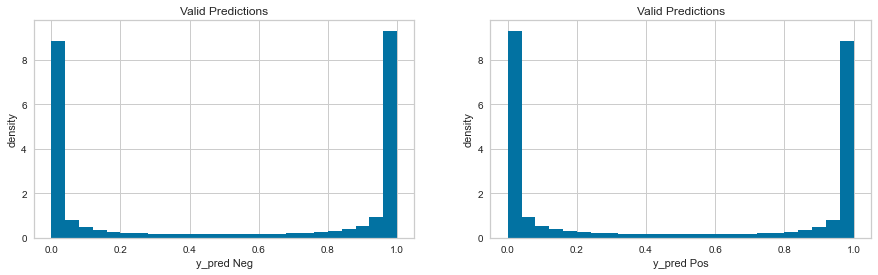

In [457]:
plt.figure(figsize=(15, 4))

plt.subplot(1,2,1)
plt.hist(y_pred_proba_neg, bins=25, density=True, color='b')
plt.xlabel('y_pred Neg')
plt.ylabel('density')
plt.title('Valid Predictions');

plt.subplot(1,2,2)
plt.hist(y_pred_proba_pos, bins=25, density=True, color='b')
plt.xlabel('y_pred Pos')
plt.ylabel('density')
plt.title('Valid Predictions');
#plt.legend();

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Nos gráficos acima, observamos que muitas das previsões estão próximas de 0 ou 1, isso significa que em muitos casos as previsões do classificador têm alta confiança.  
</div>

#### 3.1.2.2. Curva ROC

AUC     : 0.98787 
F1-score: 0.94066
F1-score: 0.94111 threshold(0.47)


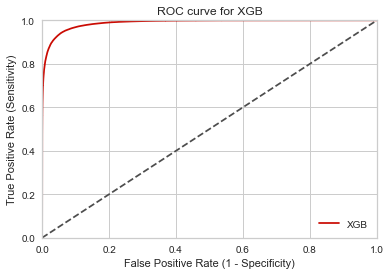

In [470]:
threshold = .47

y_pred_threshold     = (y_pred_proba_pos>threshold).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_proba_pos)

plot_roc_curve(fpr, tpr, label="XGB");
#plt.show()

print('AUC     : {:2.5f} '.format(metrics.roc_auc_score(y_valid, y_pred_proba_pos) ))
print('F1-score: {:2.5f}'.format(metrics.f1_score(y_valid, (y_pred_proba_pos>.5))))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y_valid, y_pred_threshold), threshold))

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Uma Curva ROC com o score muito alto, agora vamos dar uma olhada na calibração do modelo.    
</div>

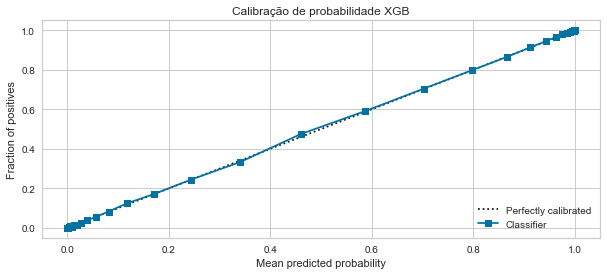

In [471]:
plt.figure(figsize=(10, 4))
CalibrationDisplay.from_predictions(y_valid, y_pred_proba_pos, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Calibração de probabilidade XGB')
plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
No gráfico de calibração acima, a curva é quase uma linha reta, o que significa que as probabilidades previstas são quase exatas. 
</div>

#### 3.1.2.3. Shap
SHAP (SHapley Additive exPlanations) é uma técnica usada para interpretar os "black-box models" para explicar a saída de qualquer modelo de Machine Learning. O SHAP mede o impacto das variáveis, levando em consideração a interação com outras variáveis, os valores de Shapley calculam a importância de uma variável comparando o que um modelo prevê com e sem a variável. No entanto, como a ordem na qual um modelo vê a variável pode afetar suas previsões, isso é feito em todas as ordens possíveis, para que as variáveis sejam comparados de maneira justa. [fonte](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83)

**Quais são as vantagens?**

- Interpretabilidade global: <br>
Os SHAP Values podem mostrar o quanto cada preditor contribui, positiva ou negativamente, para a variável de alvo.  É como o gráfico de importância da variável, mas é capaz de mostrar a relação positiva ou negativa de cada variável com o alvo.<p>

- Interpretabilidade local: <br>
Cada observação obtém seu próprio conjunto de SHAP Values, isso aumenta muito sua transparência. 

In [84]:
%%time 
# https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/
idx_sample        = X_train.sample(n=400000).index.to_list()
X_train_sample    = X_train.loc[idx_sample] 
X_train_sample_sc = pd.DataFrame(sc.transform(X_train_sample), columns=X_train_sample.columns)
y_train_sample    = y_train.loc[idx_sample]

free_gpu_cache()

explainer         = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_sample_sc) 

CPU times: total: 1min 32s
Wall time: 1min 29s


##### 3.1.2.3.1. Feature Importance 

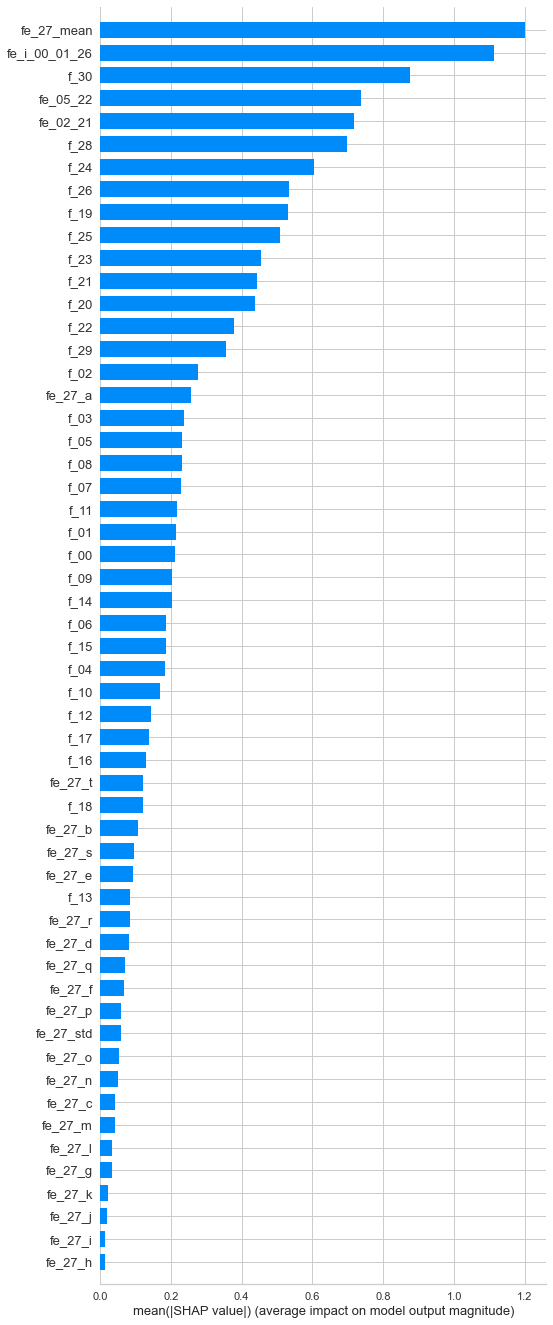

In [87]:
max_feature = X_train_sample_sc.shape[1]

shap.summary_plot(shap_values_train, 
                  X_train_sample_sc, 
                  plot_type   = "bar", 
                  max_display = max_feature)

##### 3.1.2.3.2. Impacto das variáveis

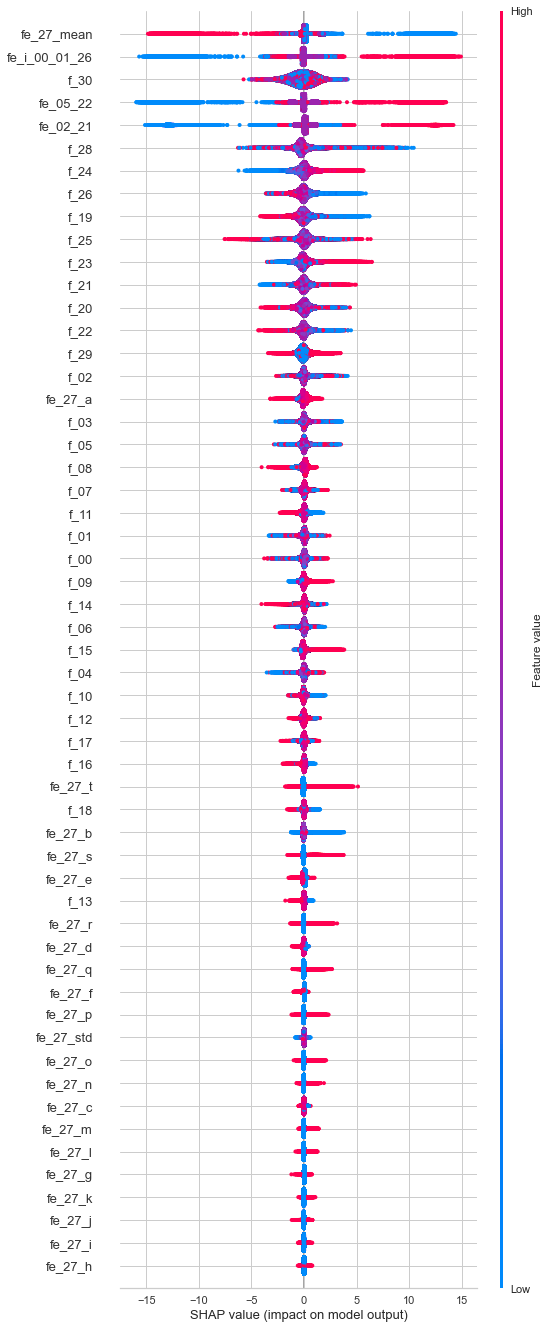

In [88]:
%%time 
shap.summary_plot(shap_values_train, X_train_sample_sc, max_display=max_feature)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Podemos observar acima no gráfico de importância das variáveis, que temos 5 variáveis que criamos estão entre as 25 primeiras variáveis.
- A variável fe_27_mean, impacta negativamente; 
- As variáveis fe_i_00_01_26, fe_05_22 e fe_02_21, impactam prositivamente o modelo.      
</div>

- Salvar os datasets

In [38]:
jb.dump(df3_train_fe_1, path+'Data/pkl/df3_train_fe_2.pkl.z')
jb.dump(df3_test_fe_1, path+'Data/pkl/df3_test_fe_2.pkl.z')

del df3_train_fe_1, df3_test_fe_1

## 3.1.3.1. Outlier

In [39]:
def outlier_create_feature_check(df_train_, df_test_, col_, qt_inferior_=.25, qt_superior_=.75):
    
    percentil25 = df_train_[col_].quantile(qt_inferior_)
    percentil75 = df_train_[col_].quantile(qt_superior_)

    iqr= percentil75 - percentil25 
    
    limite_inferior = percentil25 - 1.5 * iqr
    limite_superior = percentil75 + 1.5 * iqr

    col_oltlier = 'fe_{}_outlier'.format(col_)
    
    df_train_[col_oltlier] = 0 
    df_test_[col_oltlier]  = 0 

    df_train_[col_oltlier][df_train_[col_]>limite_superior] = 1
    df_train_[col_oltlier][df_train_[col_]<limite_inferior] = 1

    df_test_[col_oltlier][df_test_[col_]>limite_superior] = 1
    df_test_[col_oltlier][df_test_[col_]<limite_inferior] = 1
    
    print(df_train_[col_oltlier].value_counts())
    print()
    
    return df_train_, df_test_

In [40]:
def outlier_create_feature_check(df_train_, df_test_, cols_outlirs_, qt_inferior_=.25, qt_superior_=.75, 
                                 zero_outliers_=True):
    
    col_oltlier = 'fe_outlier'

    if zero_outliers_:
        df_train_[col_oltlier] = 0 
        df_test_[col_oltlier]  = 0 

    for c in cols_outlirs_:
        
        percentil25 = df_train_[c].quantile(qt_inferior_)
        percentil75 = df_train_[c].quantile(qt_superior_)

        iqr= percentil75 - percentil25 

        limite_inferior = percentil25 - 1.5 * iqr
        limite_superior = percentil75 + 1.5 * iqr

        df_train_[col_oltlier][df_train_[c]>limite_superior] = 1
        df_train_[col_oltlier][df_train_[c]<limite_inferior] = 1

        df_test_[col_oltlier][df_test_[c]>limite_superior] = 1
        df_test_[col_oltlier][df_test_[c]<limite_inferior] = 1

        print('Com a variável {}'.format(c))
        print(df_train_[col_oltlier].value_counts())
        print()

    return df_train_, df_test_

In [41]:
df3_train_fe_2 = jb.load(path + 'Data/pkl/df3_train_fe_2.pkl.z' )
df3_test_fe_2  = jb.load(path + 'Data/pkl/df3_test_fe_2.pkl.z' )

df3_train_fe_2.shape, df3_test_fe_2.shape

((900000, 59), (700000, 58))

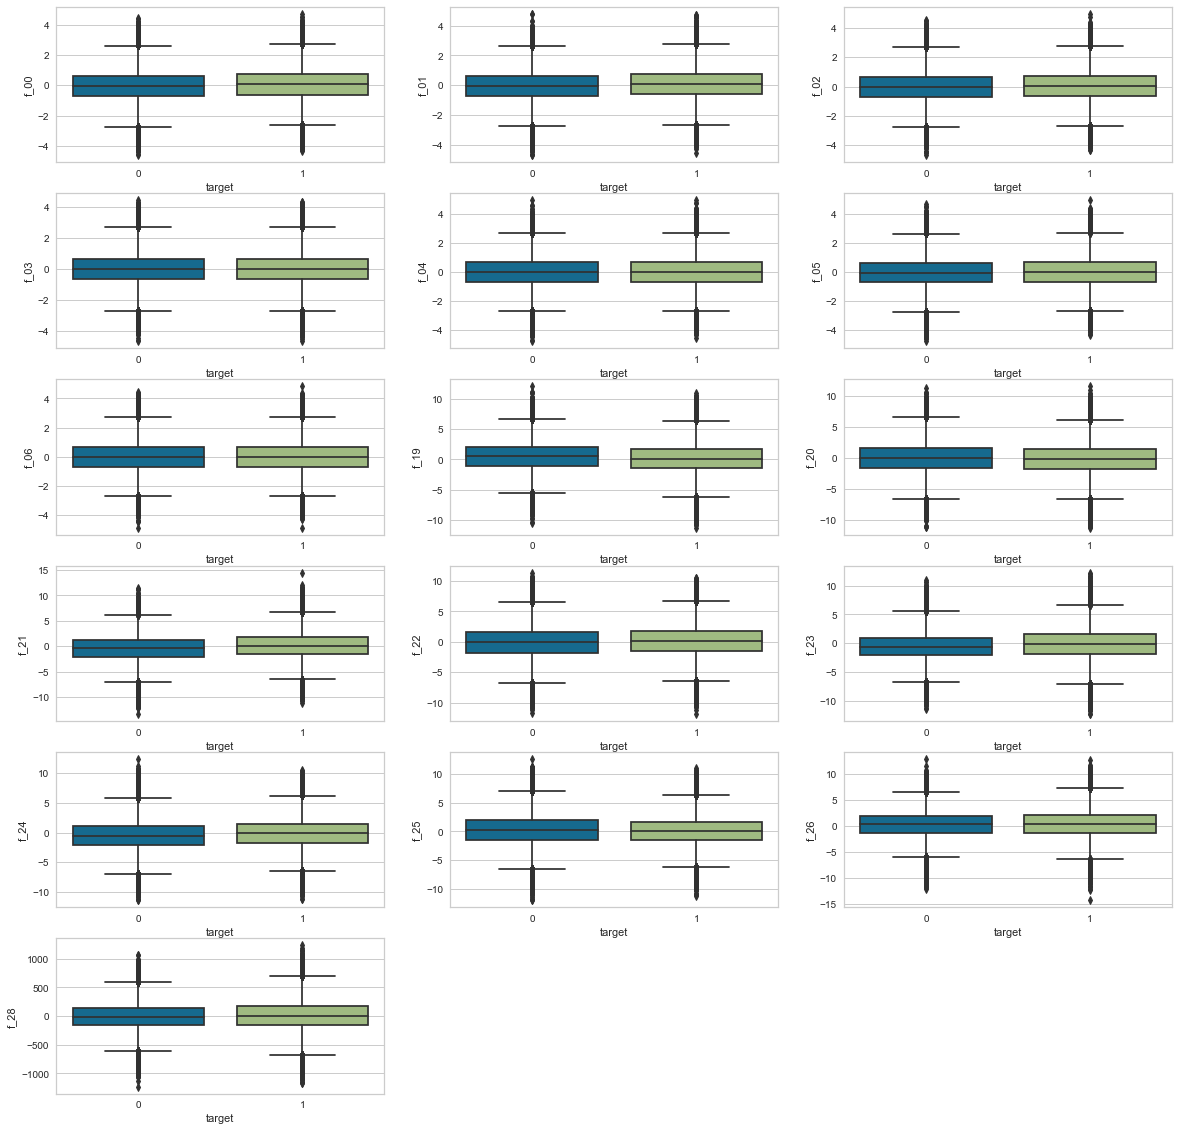

In [42]:
f, ax = plt.subplots(figsize=(20, 20))

for i, col in enumerate(feature_float): 
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.boxplot(data=df3_train_fe_2, x=target, y=col)   

In [43]:
df3_train_fe_2_outlier, df3_test_fe_2_outlier = \
outlier_create_feature_check(df3_train_fe_2.copy(), 
                             df3_test_fe_2.copy(), 
                             cols_outlirs_ = ['f_26'], 
                             qt_inferior_  = .2, # .2
                             qt_superior_  = .75, # .75
                             zero_outliers_= True)

Com a variável f_26
0    896476
1      3524
Name: fe_outlier, dtype: int64



In [44]:
%%time 

seed   = 12359
params = {'objective'         : 'binary:logistic',             
          'eval_metric'       : 'auc',            
          'n_estimators'      : 1000,             
          'random_state'      : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model  = xgb.XGBClassifier(**params)
scaler = QuantileTransformer(output_distribution='normal', random_state=0)

feature_drop_cor = ['fe_27_sum', 'fe_27_count_zero', 'fe_27_count_unique']

X      = df3_train_fe_2_outlier.drop(target, axis=1).copy()
X      = X.drop(feature_drop_cor, axis=1).copy()
y      = df3_train_fe_2_outlier[target]
X_test = df3_test_fe_2_outlier.drop(feature_drop_cor, axis=1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.29,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

model, sc, y_pred_proba_neg, y_pred_proba_pos = \
    model_train(model, 'xgb_fe_02_outlier', 
                X, 
                X_train, 
                X_valid, 
                X_test, 
                scaler, 
                print_feature_cor_=False)

# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832 - 01
# AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476 - 02 

AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476

Probabilidade do modelo
Prever negativo: 0.51413
Prever positivo: 0.48587


CPU times: total: 1min 58s
Wall time: 1min 37s


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Para o tratamento dos outlirs fiz diversos testes, a variável que teve molhor desempenho foi F_26, bantendo o score anterior.
    
Vamos dar uma olhada no Shap. 
    
</div>

In [432]:
%%time 
# referencia: https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/
idx_sample        = X_train.sample(n=500000).index.to_list()
X_train_sample    = X_train.loc[idx_sample] 
X_train_sample_sc = pd.DataFrame(sc.transform(X_train_sample), columns=X_train_sample.columns)

free_gpu_cache()

explainer         = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_sample_sc) 

CPU times: total: 2min 15s
Wall time: 2min 8s


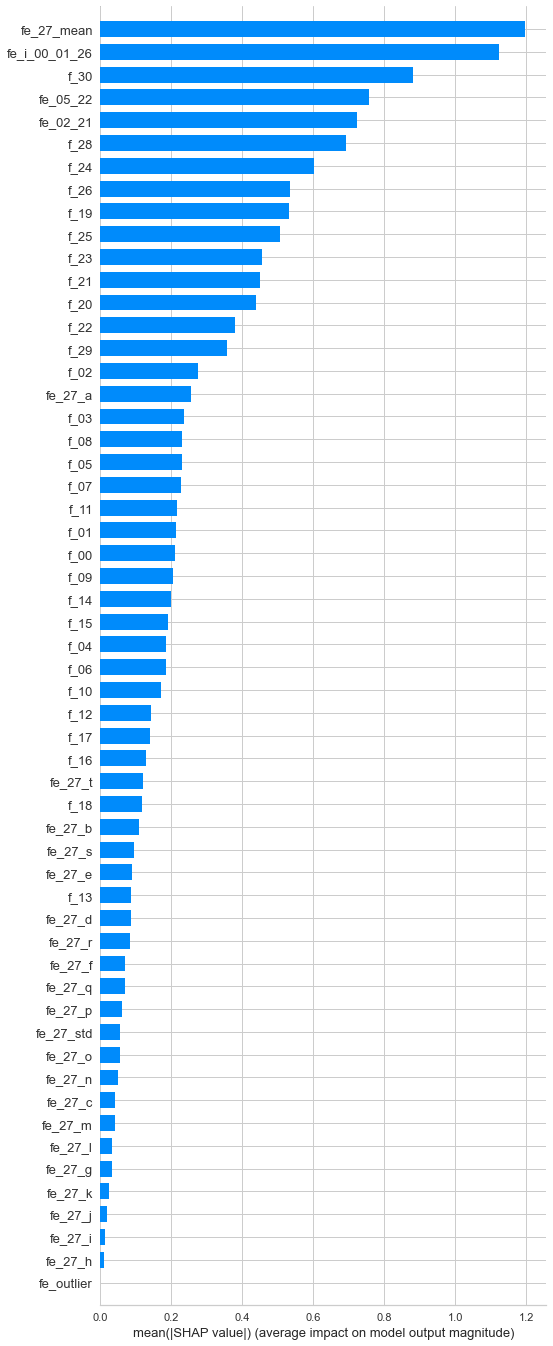

In [433]:
max_feature = X_train_sample_sc.shape[1]

shap.summary_plot(shap_values_train, 
                  X_train_sample_sc, 
                  plot_type   = "bar", 
                  max_display = max_feature)

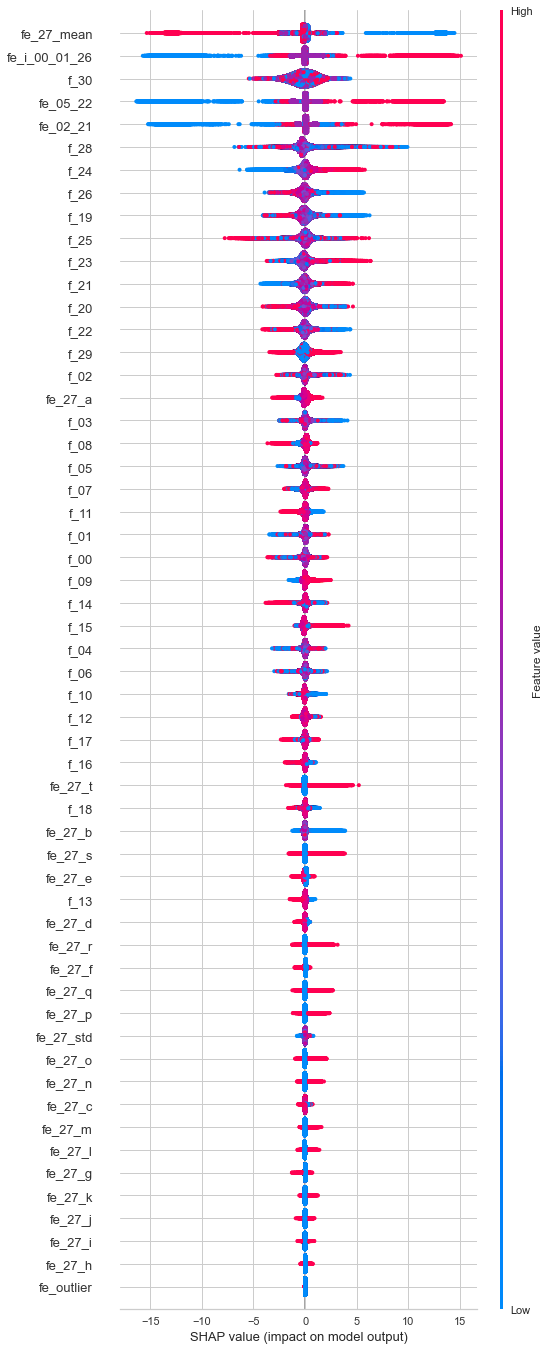

CPU times: total: 3min 34s
Wall time: 3min 34s


In [314]:
%%time 
shap.summary_plot(shap_values_train, X_train_sample_sc, max_display=max_feature)
free_gpu_cache()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Observando o gráfico de importância das variáveis, a variável que identifica os outlirs é a menos importante, mesmo assim vamos permanecer com ela no dataset, pois de alguma forma essa variável ajuda o modelo a capturar algum padrão. 
    
    
</div>

- Salvar o dataset.

In [45]:
jb.dump(df3_train_fe_2_outlier, path+'Data/pkl/df3_train_fe_3.pkl.z')
jb.dump(df3_test_fe_2_outlier, path+'Data/pkl/df3_test_fe_3.pkl.z')

del df3_train_fe_2, df3_test_fe_2, df3_train_fe_2_outlier, df3_test_fe_2_outlier

## 3.4. PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis para os modelos.


In [46]:
df3_train_fe_3 = jb.load(path + 'Data/pkl/df3_train_fe_3.pkl.z' )
df3_test_fe_3  = jb.load(path + 'Data/pkl/df3_test_fe_3.pkl.z' )

df3_train_fe_3.shape, df3_test_fe_3.shape

((900000, 60), (700000, 59))

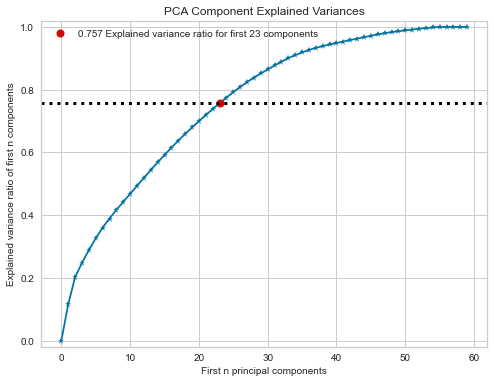

In [47]:
feature_pca = feature_float
feature_pca = df3_train_fe_3.columns.to_list()
feature_pca.remove(target)

sc          = QuantileTransformer(output_distribution='normal', random_state=0)

sc.fit_transform(df3_train_fe_3[feature_pca])

df3_train_fe_3_sc = pd.DataFrame(sc.transform(df3_train_fe_3[feature_pca]), columns=feature_pca)
df3_test_fe_3_sc  = pd.DataFrame(sc.transform(df3_test_fe_3[feature_pca]), columns=feature_pca)

pca           = PCA(random_state=12359)
df3_train_pca = pca.fit_transform(df3_train_fe_3_sc)

skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));

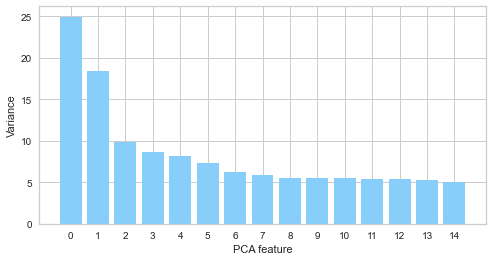

In [48]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Como podemos observar acima, o processo da PCA gerou apenas 2 componente que repesentam 99% da variabilidade dos dados, vamos cria uma novas variáveis e fazer os testes.
    
</div>

In [49]:
n_components  = 2
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]

df3_train_fe_3[pca_feats] = pd.DataFrame(pca.fit_transform(df3_train_fe_3_sc), columns=pca_feats)
df3_test_fe_3[pca_feats]  = pd.DataFrame(pca.transform(df3_test_fe_3_sc), columns=pca_feats)

df3_train_fe_3.filter(regex=r'fe_pca').head()

,fe_pca_0,fe_pca_1
0,-3.637714,-5.339258
1,-4.160857,-5.274908
2,-3.205235,5.057066
3,-3.635226,-5.175442
4,-2.891048,-0.461735


### 3.4.1. Modelagem 

In [50]:
%%time 

seed   = 12359
params = {'objective'         : 'binary:logistic',             
          'eval_metric'       : 'auc',            
          'n_estimators'      : 1000,             
          'random_state'      : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model  = xgb.XGBClassifier(**params)
scaler = QuantileTransformer(output_distribution='normal', random_state=0)

feature_drop_cor = ['fe_27_sum', 'fe_27_count_zero', 'fe_27_count_unique']

X      = df3_train_fe_3.drop(target, axis=1).copy()
X      = X.drop(feature_drop_cor, axis=1).copy()
y      = df3_train_fe_3[target]
X_test = df3_test_fe_3.drop(feature_drop_cor, axis=1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.29,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

model, sc, y_pred_proba_neg, y_pred_proba_pos = \
    model_train(model, 'xgb_fe_03_pca',  
                X, 
                X_train, 
                X_valid, 
                X_test, 
                scaler, 
                print_feature_cor_=False)

# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832 - 01
# AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476 - 02 
# AUC: 0.98824 - F1-score: 0.94175 - L. loss: 1.95245 - 03

AUC: 0.98824 - F1-score: 0.94175 - L. loss: 1.95245

Probabilidade do modelo
Prever negativo: 0.51405
Prever positivo: 0.48595


CPU times: total: 2min 11s
Wall time: 1min 40s


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Melhoramos novamente, vamos dar uma olhada no Shap para confirma a importância das novas variáveis. 
</div>

### 3.4.3. Shap

In [328]:
%%time 
# referencia: https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/
idx_sample        = X_train.sample(n=500000).index.to_list()
X_train_sample    = X_train.loc[idx_sample] 
X_train_sample_sc = pd.DataFrame(sc.transform(X_train_sample), columns=X_train_sample.columns)

free_gpu_cache()

explainer         = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_sample_sc) 

CPU times: total: 1min 54s
Wall time: 1min 53s


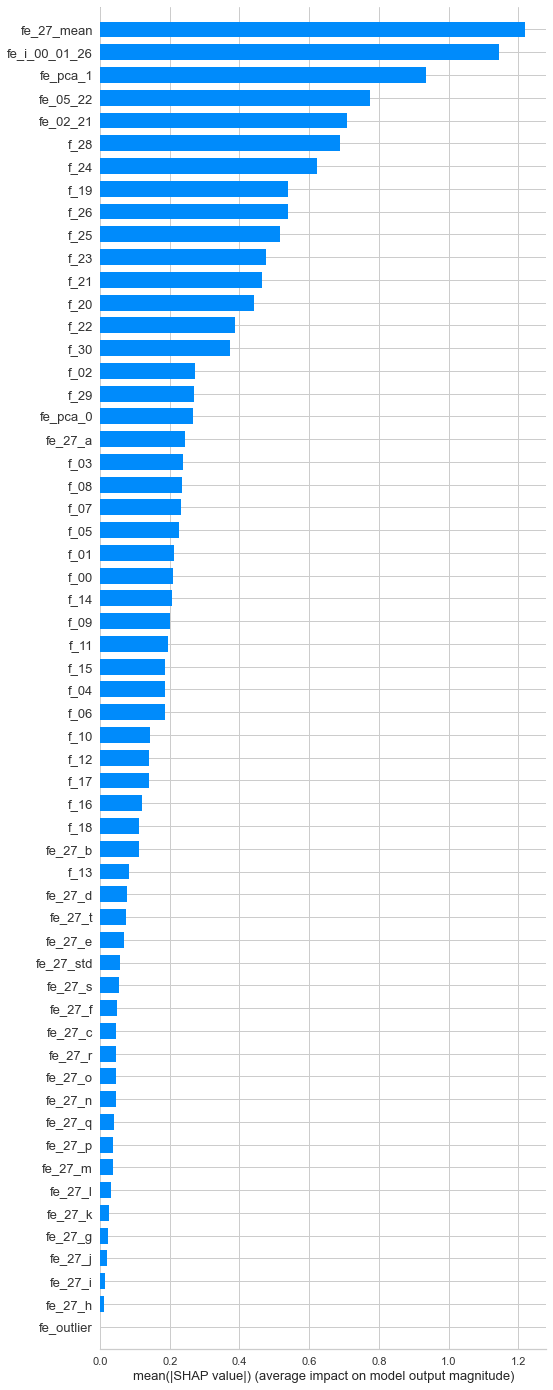

In [329]:
max_feature = X_train_sample_sc.shape[1]

shap.summary_plot(shap_values_train, 
                  X_train_sample_sc, 
                  plot_type   = "bar", 
                  max_display = max_feature)

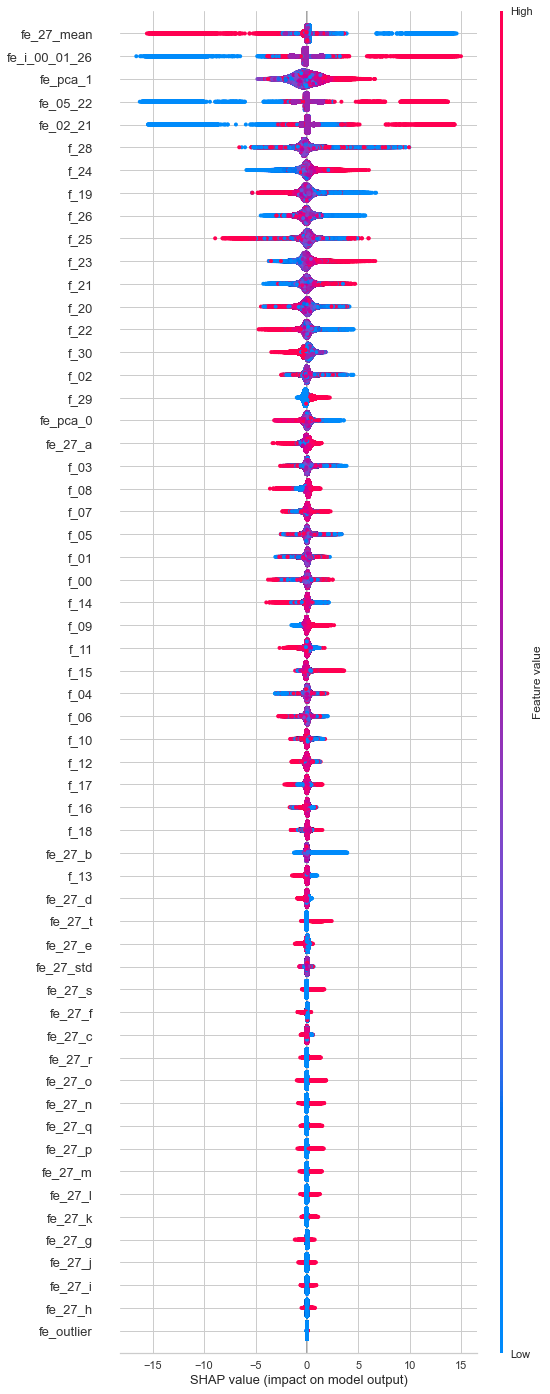

CPU times: total: 2min 53s
Wall time: 2min 53s


In [330]:
%%time 
shap.summary_plot(shap_values_train, X_train_sample_sc, max_display=max_feature)
free_gpu_cache()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Entre as duas PCAs que foram criadas a mehor que posicionada é a fe_pca_1 na terceira colocação no geral. 
</div>

- Salvar os dataset. 

In [51]:
jb.dump(df3_train_fe_3, path+'Data/pkl/df3_train_fe_4.pkl.z')
jb.dump(df3_test_fe_3, path+'Data/pkl/df3_test_fe_4.pkl.z')

del df3_train_fe_3, df3_test_fe_3

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. VALIDAÇÃO CRUZADA </h1>    
</div>

In [558]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [541]:
def df_return_preds_stacking(model_name_=None, path_='', target_='target', level=1): 

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name_==None: 
        model_name_=''

    for i, p in enumerate(paths): 

        p = path_ + p 

        name_file_pkl     = glob.glob(p + '/'+ model_name_ + '*.pkl.z')
        dic_preds_mdl_pkl = dict()    

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(p + '\\', '').replace('.pkl.z','') 
            #y_model_pkl           = jb.load(p_name)
            df_pkl =jb.load(p_name)

            if i==0: 
                x_proba = df_pkl
            else: 
                x_proba = df_pkl['y_proba']        

            dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba

        if i==0:
            df_ts = pd.DataFrame(dic_preds_mdl_pkl)
        else: 
            df_tr = pd.DataFrame(dic_preds_mdl_pkl) 
            df_tr[target_] = df_pkl['y_proba']
            
    return df_tr, df_ts 

In [574]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False, 
                    save_predict_=False, level_='1', cutoff_value_save_=.6, 
                    train_with_created_folds_=False):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0  
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    preds           = []
    model           = []
    folds           = []
    cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'y_proba']
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        for i in range(fold_):         
            folds.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(fold_, i+1)))
    else:
        #folds = KFold(n_splits=fold_, shuffle=True, random_state=12359)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=12359)
        folds = folds.split(X_, y_, groups=y_)
        

    for i, scaler_ in enumerate(scalers_): 

        time_start  = datetime.now()
        score       = [] 
        score_lloss = []
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))        
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        y_pred_test_prob_oof = 0      
        second_level         = np.zeros((X_.shape[0], 5))        

        for fold, (trn_idx, val_idx) in enumerate(folds): 

            time_fold_start = datetime.now()
            
            if train_with_created_folds_:
                trn_idx = folds[fold][trn_idx]
                val_idx = folds[fold][val_idx]
            
            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
                      
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)[:,1]    
            y_pred_val      = (y_pred_val_prob>.5).astype(int)

            y_pred_test_prob_oof += model_.predict_proba(X_tst)[:, 1] / fold_
                        
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = y_val.values 
            second_level[val_idx, 3] = y_pred_val 
            second_level[val_idx, 4] = y_pred_val_prob
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
            f1    = metrics.f1_score(y_val, y_pred_val) 
            prec  = metrics.log_loss (y_val, y_pred_val)
            
            score.append(auc)     
            score_lloss.append(prec)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['auc_'+str(fold+1)] = auc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
            print(msg.format(fold+1, auc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_proba           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_proba['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_proba[col] = df_proba[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_llg_mean = np.mean(score_lloss)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        msg ='[Mean Fold] AUC: {:2.5f} std: {:2.5f} - L.Loss {:2.5f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_llg_mean, time_end))
        print('='*taco)
        print()
        
        if print_report_:
            y_pred = df_proba[df_proba['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_proba[df_proba['scaler']==str(string_scaler)]['y']
            print(metrics.classification_report(y_vl, y_pred))
                                 
        # Salvar as predições
        if save_submission_:            
            save_data_model(model_             = model_, 
                            model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                            path_              = path_,                             
                            df_                = df_proba,       # stacking
                            y_pred_test_prob_  = y_pred_test_prob_oof,   # stacking 
                            y_pred_test_subm_  = y_pred_test_prob_oof,   # sumission 
                            score_             = score_mean, 
                            seed_              = seed_, 
                            level_             = level_, 
                            target_            = target_, 
                            cutoff_value_      = cutoff_value_save_) 
            
    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()
    
    free_gpu_cache()
    
    return model, df_proba , feature_imp

In [599]:
df3_train_fe_4 = jb.load(path + 'Data/pkl/df3_train_fe_4.pkl.z' )
df3_test_fe_4  = jb.load(path + 'Data/pkl/df3_test_fe_4.pkl.z' )

df3_train_fe_4.shape, df3_test_fe_4.shape

((900000, 62), (700000, 61))

In [544]:
feature_drop_cor = ['fe_27_sum', 'fe_27_count_zero', 'fe_27_count_unique']

X      = df3_train_fe_4.drop(target, axis=1).copy()
X      = X.drop(feature_drop_cor, axis=1).copy()
y      = df3_train_fe_4[target]
X_test = df3_test_fe_4.drop(feature_drop_cor, axis=1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.29,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Abaixo vamos gerar os k fold de treino, a finalidade é utilizar em todo processo de modelagem daqui para frente.   
</div>

In [570]:
def create_kfolds(folds, X_, y_):

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=12359)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X_, y_, groups=y_)):   
        idx  = {'trn_idx': trn_idx, 'val_idx': val_idx}
        file = path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(folds,fold+1)
        jb.dump(idx, file)
        print('Fold: {}'.format(fold+1))

In [571]:
create_kfolds(5, X, y)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [572]:
create_kfolds(10, X, y)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


## 4.1 Treinar com 5 Folds

In [576]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 5000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model_name = 'xgb_fe_04_cv_kfold_5'

delete_files(model_name)

model, df_proba, feature_imp = \
    cross_val_model(model_             = xgb.XGBClassifier(**params),
                    model_name_        = model_name,
                    X_                 = X,
                    y_                 = y,
                    X_test_            = X_test,
                    target_            = target,
                    scalers_           = scalers,
                    fold_              = 5,  
                    lb_                = None,
                    path_              = path,
                    seed_              = seed, 
                    feature_scaler_    = None, 
                    print_report_      = True, 
                    save_submission_   = True,#  
                    cutoff_value_save_ = .6, 
                    train_with_created_folds_ = True
                   )

print()

# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832 - 01
# AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476 - 02 
# AUC: 0.98824 - F1-score: 0.94175 - L. loss: 1.95245 - 03
# AUC: 0.98845 std: 0.00020 - L.Loss 1.93220 - 0h 8m 36s - 04 
# AUC: 0.98856 std: 0.00015 - L.Loss 1.91961 - 0h 14m 6s

Scaler: QuantileTransformer - n_estimators: 5000
[Fold 1] AUC: 0.98865 - F1-score: 0.94277 - L. Loss: 1.91788  - 0h 2m 22s
[Fold 2] AUC: 0.98845 - F1-score: 0.94267 - L. Loss: 1.92210  - 0h 3m 40s
[Fold 3] AUC: 0.98844 - F1-score: 0.94202 - L. Loss: 1.94475  - 0h 2m 27s
[Fold 4] AUC: 0.98845 - F1-score: 0.94237 - L. Loss: 1.93131  - 0h 2m 48s
[Fold 5] AUC: 0.98883 - F1-score: 0.94392 - L. Loss: 1.88200  - 0h 2m 47s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.98856 std: 0.00015 - L.Loss 1.91961 - 0h 14m 6s

              precision    recall  f1-score   support

           0       0.94      0.95      0.95    462161
           1       0.94      0.94      0.94    437839

    accuracy                           0.94    900000
   macro avg       0.94      0.94      0.94    900000
weighted avg       0.94      0.94      0.94    900000

----------------------------------------------------------------------------
Scaler Best: QuantileTransformer

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Melhoramos novamente o score, principalmente na submissão, a validação cruzada é mais robusta, vamos treina novamente com 10 folds. 
</div>

## 4.2 Treinar com 10 Folds

In [ ]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 5000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model_name = 'lgb_fe_05_cv_kfold_5'

delete_files(model_name)

model, df_proba, feature_imp = \
    cross_val_model(model_             = lgb.LGBMClassifier(**params),
                    model_name_        = model_name,
                    X_                 = X,
                    y_                 = y,
                    X_test_            = X_test,
                    target_            = target,
                    scalers_           = scalers,
                    fold_              = 5,  
                    lb_                = None,
                    path_              = path,
                    seed_              = seed, 
                    feature_scaler_    = None, 
                    print_report_      = True, 
                    save_submission_   = True,#  
                    cutoff_value_save_ = .6, 
                    train_with_created_folds_ = True
                   )

print()

# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832 - 01
# AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476 - 02 
# AUC: 0.98824 - F1-score: 0.94175 - L. loss: 1.95245 - 03
# AUC: 0.98845 std: 0.00020 - L.Loss 1.93220 - 0h 8m 36s - 04 

In [575]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 5000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model_name = 'xgb_fe_05_cv_kfold_10'

delete_files(model_name)

model, df_proba, feature_imp = \
    cross_val_model(model_             = xgb.XGBClassifier(**params),
                    model_name_        = model_name,
                    X_                 = X,
                    y_                 = y,
                    X_test_            = X_test,
                    target_            = target,
                    scalers_           = scalers,
                    fold_              = 10, 
                    lb_                = None,
                    path_              = path,
                    seed_              = seed, 
                    feature_scaler_    = None, 
                    print_report_      = True, 
                    save_submission_   = True,#  
                    cutoff_value_save_ = .6, 
                    train_with_created_folds_ = True
                   )

free_gpu_cache()

print()

# AUC: 0.98787 - F1-score: 0.94066 - L. loss: 1.98832 - 01
# AUC: 0.98801 - F1-score: 0.94137 - L. loss: 1.96476 - 02 
# AUC: 0.98824 - F1-score: 0.94175 - L. loss: 1.95245 - 03
# AUC: 0.98845 std: 0.00020 - L.Loss 1.93220 - 0h 8m 36s - 04 
# AUC: 0.98854 std: 0.00040 - L.Loss 1.91969 - 0h 17m 21s

Scaler: QuantileTransformer - n_estimators: 5000
[Fold 1] AUC: 0.98860 - F1-score: 0.94243 - L. Loss: 1.92767  - 0h 2m 1s
[Fold 2] AUC: 0.98919 - F1-score: 0.94442 - L. Loss: 1.86204  - 0h 3m 43s
[Fold 3] AUC: 0.98850 - F1-score: 0.94421 - L. Loss: 1.87087  - 0h 4m 48s
[Fold 4] AUC: 0.98891 - F1-score: 0.94436 - L. Loss: 1.86627  - 0h 2m 38s
[Fold 5] AUC: 0.98917 - F1-score: 0.94440 - L. Loss: 1.86243  - 0h 2m 51s
[Fold 6] AUC: 0.98830 - F1-score: 0.94201 - L. Loss: 1.94647  - 0h 2m 33s
[Fold 7] AUC: 0.98858 - F1-score: 0.94179 - L. Loss: 1.94724  - 0h 2m 20s
[Fold 8] AUC: 0.98902 - F1-score: 0.94440 - L. Loss: 1.86358  - 0h 2m 27s
[Fold 9] AUC: 0.98900 - F1-score: 0.94419 - L. Loss: 1.87394  - 0h 2m 18s
[Fold 10] AUC: 0.98910 - F1-score: 0.94446 - L. Loss: 1.86435  - 0h 2m 16s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.98884 std: 0.00030 - L.Loss 1.88849 - 0h 27m 59s

              precision    recall  f1-score   support

          

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Com o aumento na quantidade de folds para o treinamento, também melhoramos o score do modelo na submissão.
</div>



### 3.1.3. Feature Importances  CV 

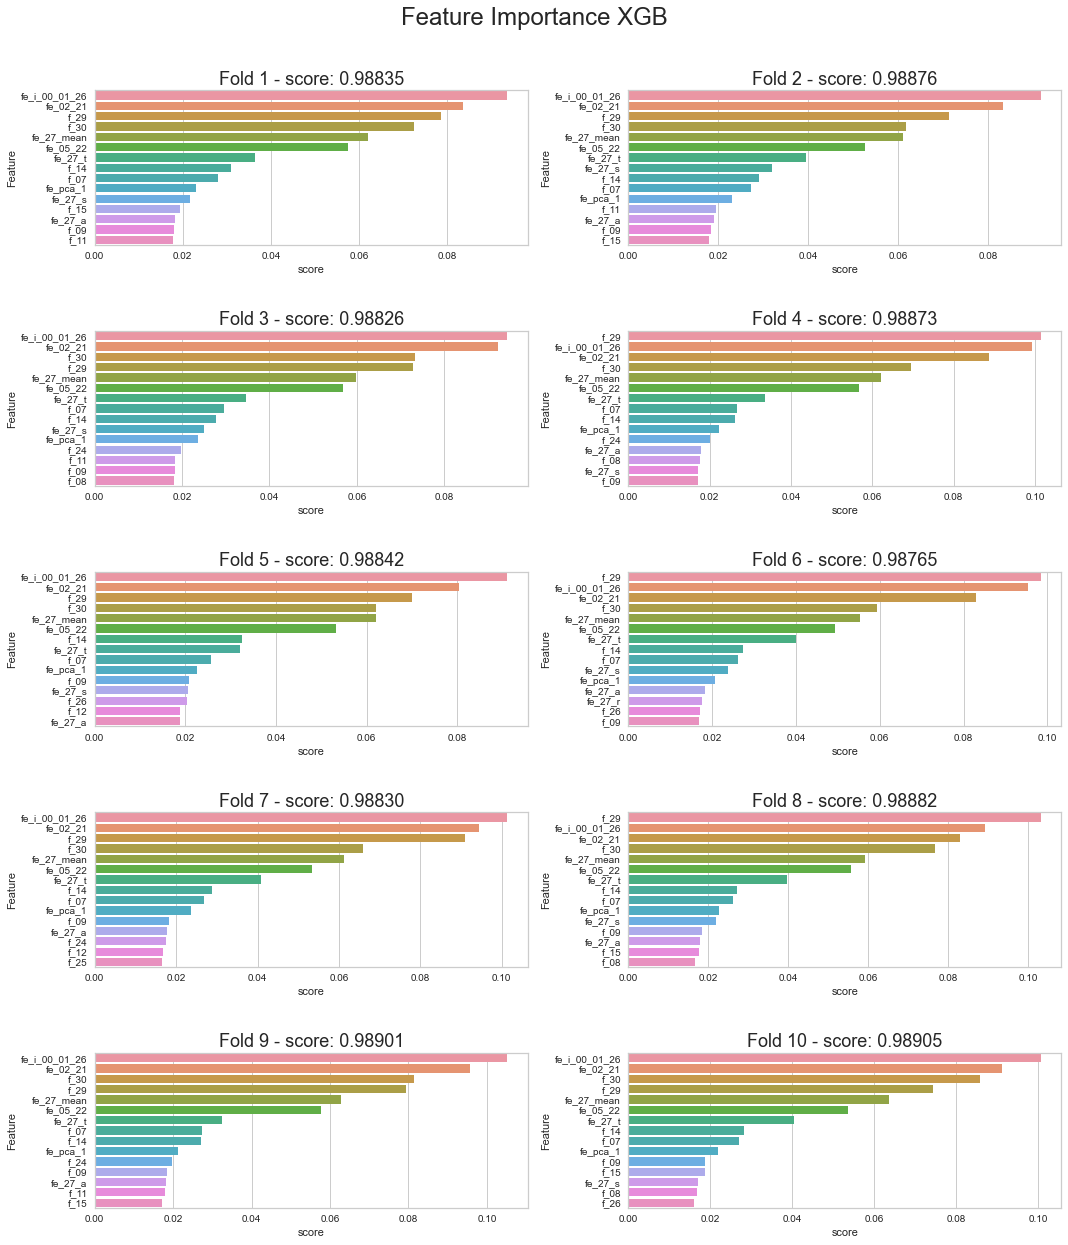

In [390]:
plt.figure(figsize=(15,20))

cols = feature_imp.filter(regex=r'fold').columns 
row  = int(len(cols)/2+1) 

for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'auc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(row,2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.01, fontsize=24);
plt.tight_layout(h_pad=3.0); 

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Nos gráficos acima, observamos que muitas das variáveis criadas estão entre as principais utilizadas pelo modelo.  
</div>

# 5. Ensamble

Primeiro vamos recuprar todas as predições e fazer um stacking simples.


In [577]:
df_tr_stacking, df_ts_stacking = \
    df_return_preds_stacking(model_name_=None, path_=path, target_=target, level=1)

df_tr_stacking.shape, df_ts_stacking.shape

((900000, 6), (700000, 5))

In [578]:
df_ts_stacking.head()

,xgb_fe_01_score_0.98787_seed_12359,xgb_fe_02_outlier_score_0.98801_seed_12359,xgb_fe_03_pca_score_0.98824_seed_12359,xgb_fe_04_cv_kfold_5_score_0.98856_seed_12359_quan,xgb_fe_05_cv_kfold_10_score_0.98884_seed_12359_quan
0,9.999996e-01,9.999994e-01,9.999994e-01,9.999947e-01,9.999975e-01
1,9.990011e-01,9.994972e-01,9.983343e-01,9.990133e-01,9.992607e-01
2,3.802915e-11,2.501860e-11,1.906443e-11,3.701941e-12,7.496444e-12
3,1.309494e-03,1.818963e-03,9.053728e-04,7.156995e-04,4.797309e-04
4,8.191358e-01,9.348348e-01,9.158336e-01,8.175915e-01,8.907846e-01


In [649]:
auc_1 = df_ts_stacking['xgb_fe_05_cv_kfold_10_score_0.98884_seed_12359_quan'].values *.7
auc_2 = df_ts_stacking['xgb_fe_04_cv_kfold_5_score_0.98856_seed_12359_quan'].values *.2
auc_3 = df_ts_stacking['xgb_fe_03_pca_score_0.98824_seed_12359'].values *.1

df_submission[target] = auc_1 + auc_2 + auc_3
df_submission.to_csv(path + 'Data/submission/xgb_fe_10_stacking_mean.csv', index=False) 

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Com a submissão da stacking, saimos de score de 0.98999 para 0.99045. 
</div>

![aaa](img/2.jpg)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Neste notebook criamos novas variáveis utilizando variáveis estatísticas, tratamento de outlirs, transformações de variaveis e uma PCA, em todo o processo de geração das novas variáveis obtive resulto melhores, utilizando o classificador XGB, o qual demostrou uma ótima clalibração principalmente para classificações negativas. Um ponto importante a destacar é que o classificado não foi ajustado, aonde podemos trabalhar para obtermos melhores resultados.  <br>
    
No treimanto dos modelos, o melhor resultado foi obtido com na validação cruzadas com 10 k folds. <br>
    
Os próximos passos são: <br> 
- Testar novos classificadores; 
- Tunning;
- Feature selection. <br>
    
    
<p>
    
FERENCIAS: <br>  
- https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction
- https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
- https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook   
- https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/
</div>